In [23]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [24]:
imagePaths = []
for dirname, _, filenames in os.walk('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [25]:
imgSize = 224

In [26]:
X = []
Y = []
hmap = {'Viral Pneumonia': 'Pneumonia', 'NORMAL': 'Normal', 'COVID-19': 'Covid-19'}
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    
    if (label == "Viral Pneumonia"):
        continue
        
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imgSize, imgSize))

    X.append(image)
    Y.append(hmap[label])
    

100%|██████████| 2905/2905 [00:24<00:00, 117.28it/s]


In [27]:
print('Covid-19:',Y.count('Covid-19'))
print('Normal:',Y.count('Normal'))
print('Pneumonia: ',Y.count('Pneumonia'))

Covid-19: 219
Normal: 1341
Pneumonia:  0


In [28]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = to_categorical(Y)

In [29]:
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [30]:
del X
del Y

In [31]:
ntimes = 6
trainY = trainY.tolist()
for i in tqdm(range(len(trainX))):
    if (trainY[i][0] == 1):
        trainX += [trainX[i]]*ntimes
        trainY += [trainY[i]]*ntimes
        
trainY = np.array(trainY)

100%|██████████| 1248/1248 [00:00<00:00, 537808.63it/s]


In [32]:
trainX = np.array(trainX).astype('float16')/255

testX = np.array(testX).astype('float16')/255

In [33]:
trainAug = ImageDataGenerator(rotation_range=20, horizontal_flip = True,fill_mode="nearest")

In [34]:
best_val_acc = 0
best_train_acc = 0
def saveModel(epoch,logs):
    val_acc = logs['val_accuracy']
    train_acc = logs['accuracy']
    global best_val_acc
    global best_train_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save('model.h5')
    elif val_acc == best_val_acc:
        if train_acc > best_train_acc:
            best_train_acc= train_acc
            model.save('model.h5')

# MODEL

In [35]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

# Train model

In [36]:
INIT_LR = 3e-4
EPOCHS = 10
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    callbacks= [LambdaCallback(on_epoch_end=saveModel),
              ],
    epochs=EPOCHS)

Train for 71 steps, validate on 312 samples
Epoch 1/10
71/71 [==============================] - 27s 374ms/step - loss: 0.2297 - accuracy: 0.9095 - val_loss: 0.0452 - val_accuracy: 0.9931
Epoch 2/10
71/71 [==============================] - 28s 388ms/step - loss: 0.0856 - accuracy: 0.9757 - val_loss: 0.0520 - val_accuracy: 0.9792
Epoch 3/10
71/71 [==============================] - 27s 379ms/step - loss: 0.0590 - accuracy: 0.9810 - val_loss: 0.0207 - val_accuracy: 0.9965
Epoch 4/10
71/71 [==============================] - 28s 388ms/step - loss: 0.0481 - accuracy: 0.9841 - val_loss: 0.0305 - val_accuracy: 0.9931
Epoch 5/10
71/71 [==============================] - 27s 379ms/step - loss: 0.0336 - accuracy: 0.9916 - val_loss: 0.0199 - val_accuracy: 0.9896
Epoch 6/10
71/71 [==============================] - 29s 404ms/step - loss: 0.0257 - accuracy: 0.9943 - val_loss: 0.0115 - val_accuracy: 0.9965
Epoch 7/10
71/71 [==============================] - 30s 418ms/step - loss: 0.0265 - accuracy: 0.99

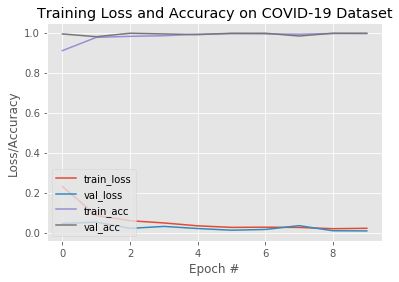

In [37]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Load best model

In [38]:
model= load_model('model.h5')

# Result on train

In [39]:
predIdxs = model.predict(trainX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.99837   1.00000   0.99918      1225
      Normal    1.00000   0.99814   0.99907      1073

    accuracy                        0.99913      2298
   macro avg    0.99919   0.99907   0.99913      2298
weighted avg    0.99913   0.99913   0.99913      2298



# Result on test

In [40]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.97778   1.00000   0.98876        44
      Normal    1.00000   0.99627   0.99813       268

    accuracy                        0.99679       312
   macro avg    0.98889   0.99813   0.99345       312
weighted avg    0.99687   0.99679   0.99681       312

